## 1. Graph Attention Networks

In [6]:
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Dataset

In [1]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="citeseer")

data = dataset[0]


C:\Users\user\anaconda3\envs\test\lib\site-packages\torch_geometric\typing.py:60: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\user\anaconda3\envs\test\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\user\anaconda3\envs\test\lib\site-packages\torch_geometric\typing.py:98: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\user\anaconda3\envs\test\Lib\site-packages\torch_sparse\_convert_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Done!


### Print information about the dataset

In [2]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: citeseer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [3]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


### Plot dataset

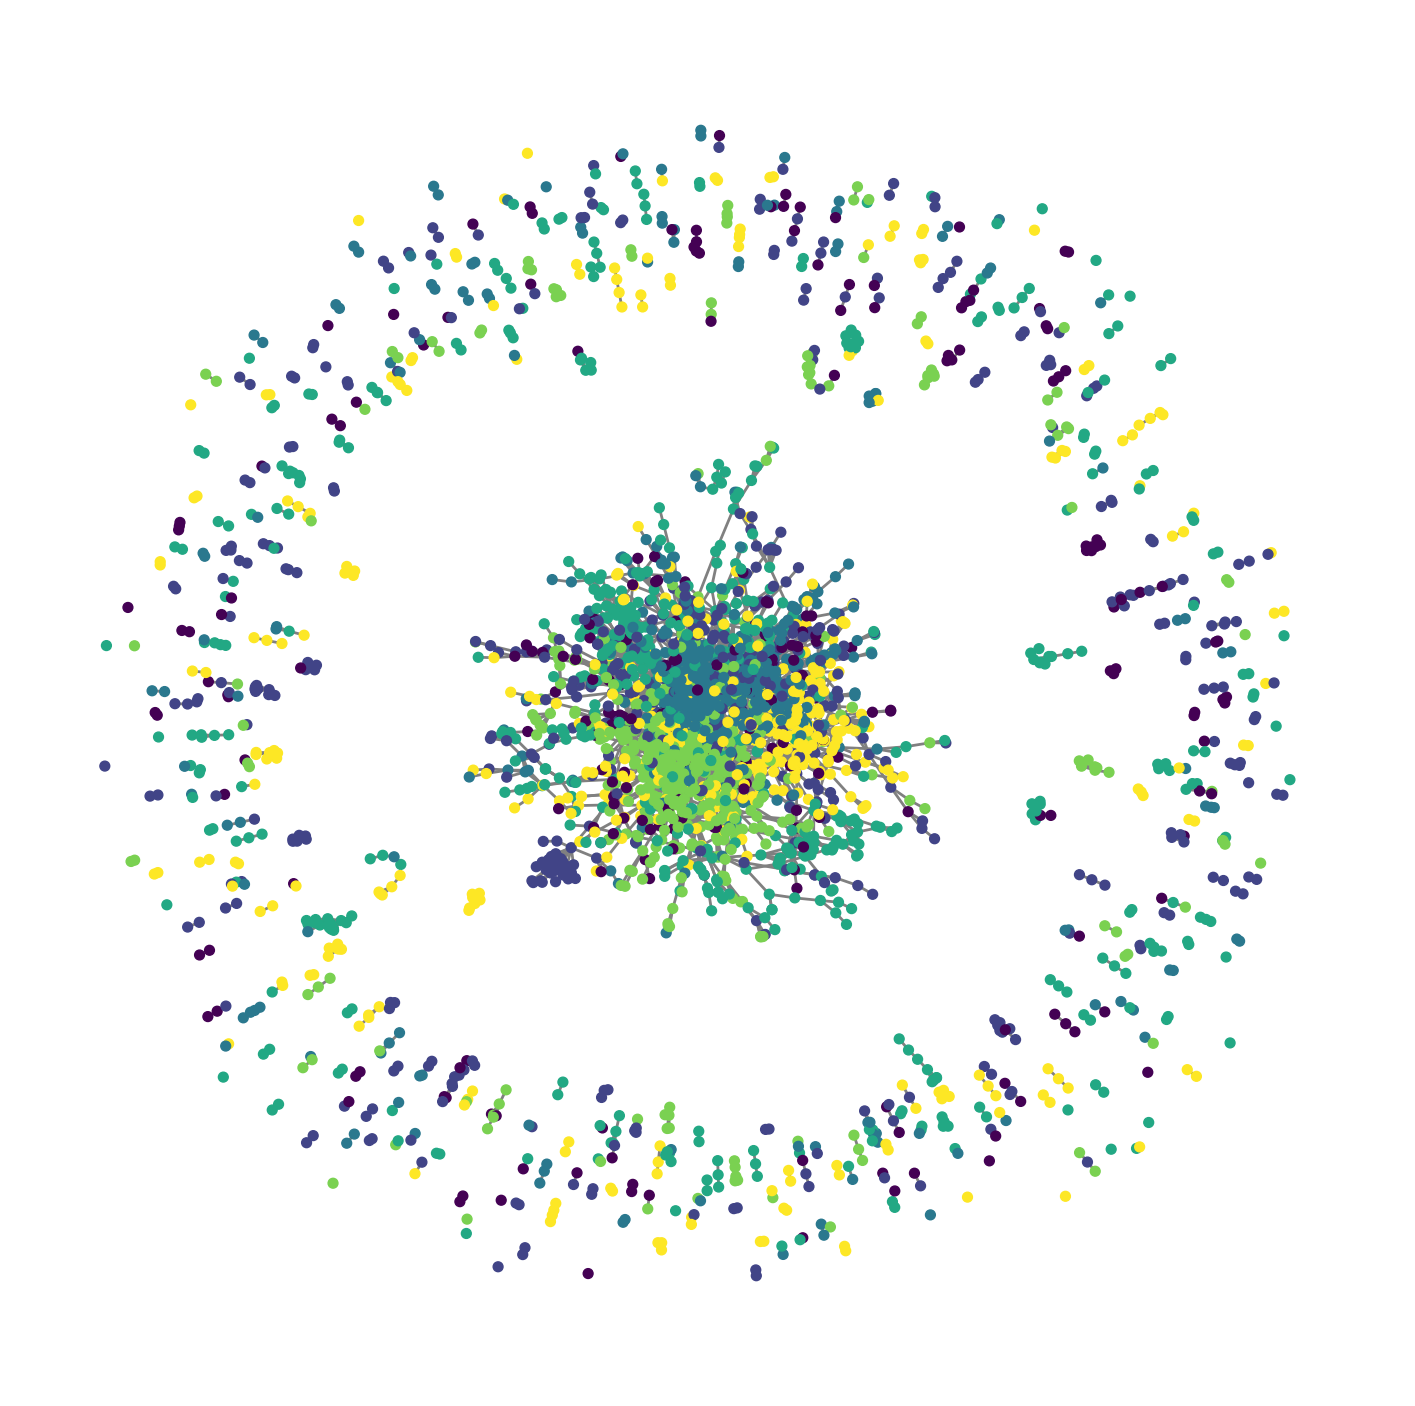

In [5]:
from torch_geometric.utils import to_networkx
# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

### Plot node degrees

<BarContainer object of 32 artists>

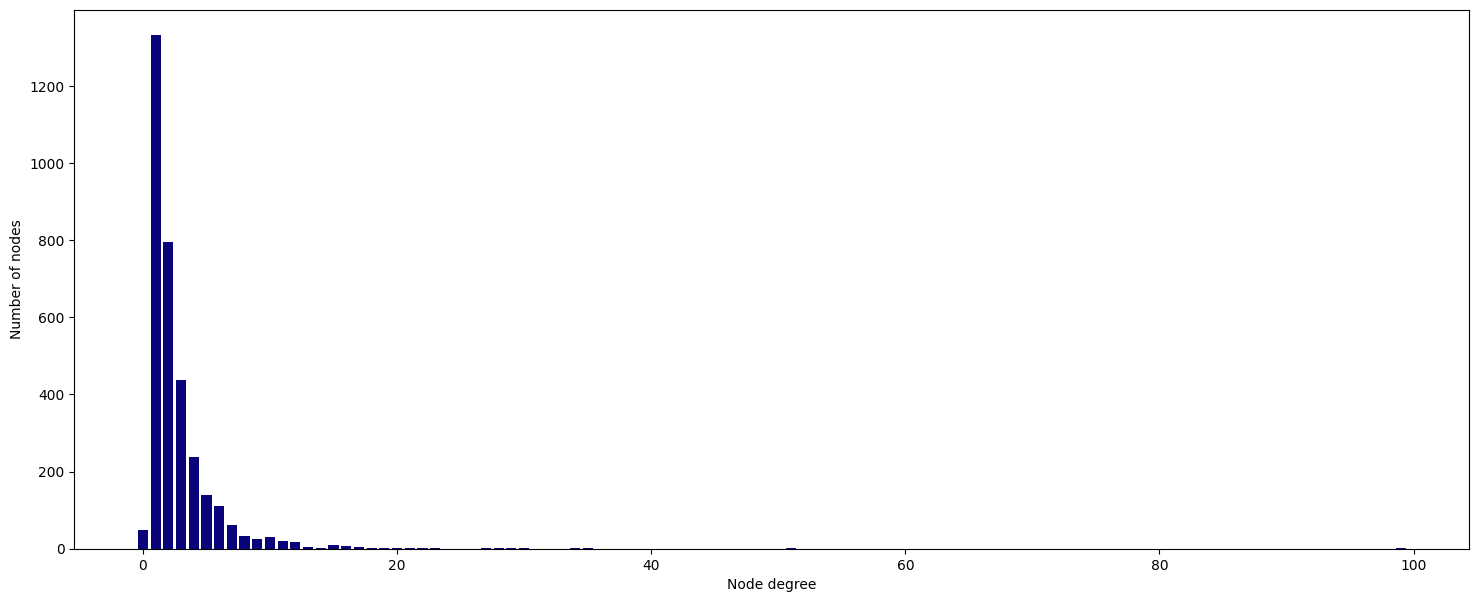

In [6]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

### Implement GAT vs. GCN

#### GCN model

In [8]:
import torch.nn.functional as F
import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

#### GAT model

In [9]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

### Train function

In [10]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [11]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

### Train GCN

In [12]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.795 | Train Acc:  15.83% | Val Loss: 1.81 | Val Acc: 11.00%
Epoch   1 | Train Loss: 1.666 | Train Acc:  59.17% | Val Loss: 1.75 | Val Acc: 35.00%
Epoch   2 | Train Loss: 1.516 | Train Acc:  69.17% | Val Loss: 1.70 | Val Acc: 41.60%
Epoch   3 | Train Loss: 1.342 | Train Acc:  78.33% | Val Loss: 1.63 | Val Acc: 44.20%
Epoch   4 | Train Loss: 1.161 | Train Acc:  75.83% | Val Loss: 1.58 | Val Acc: 43.40%
Epoch   5 | Train Loss: 1.018 | Train Acc:  75.83% | Val Loss: 1.54 | Val Acc: 40.00%

GCN test accuracy: 51.90%

CPU times: total: 13.9 s
Wall time: 2.01 s


### Train GAT

In [13]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
CPU times: total: 0 ns
Wall time: 5.03 ms


In [14]:


# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.792 | Train Acc:  23.33% | Val Loss: 1.79 | Val Acc: 17.60%
Epoch   1 | Train Loss: 1.393 | Train Acc:  85.00% | Val Loss: 1.64 | Val Acc: 50.40%
Epoch   2 | Train Loss: 1.066 | Train Acc:  91.67% | Val Loss: 1.51 | Val Acc: 59.00%
Epoch   3 | Train Loss: 0.799 | Train Acc:  93.33% | Val Loss: 1.37 | Val Acc: 64.00%
Epoch   4 | Train Loss: 0.591 | Train Acc:  95.00% | Val Loss: 1.26 | Val Acc: 67.00%
Epoch   5 | Train Loss: 0.428 | Train Acc:  95.00% | Val Loss: 1.16 | Val Acc: 67.80%

GAT test accuracy: 69.30%



### t-SNE plots

C:\Users\user\anaconda3\envs\test\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\test\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


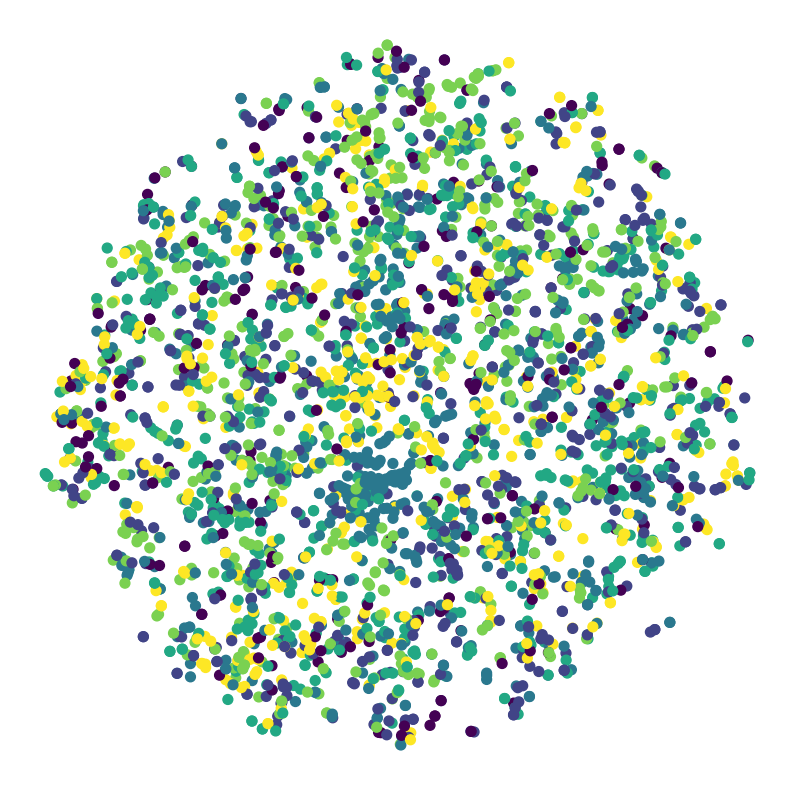

In [15]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

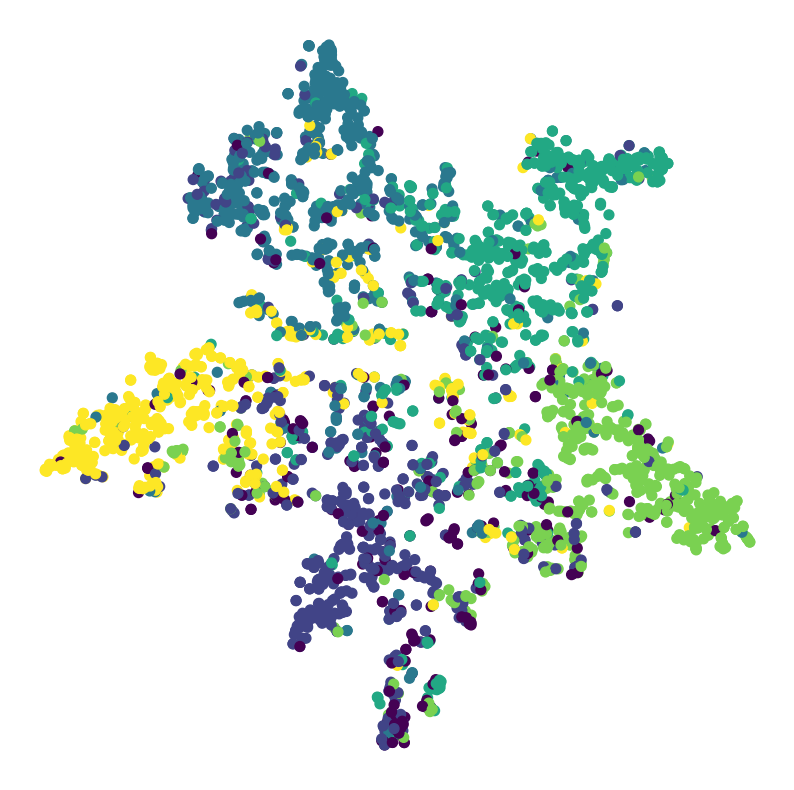

In [16]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

### Plot accuracy for each node degree

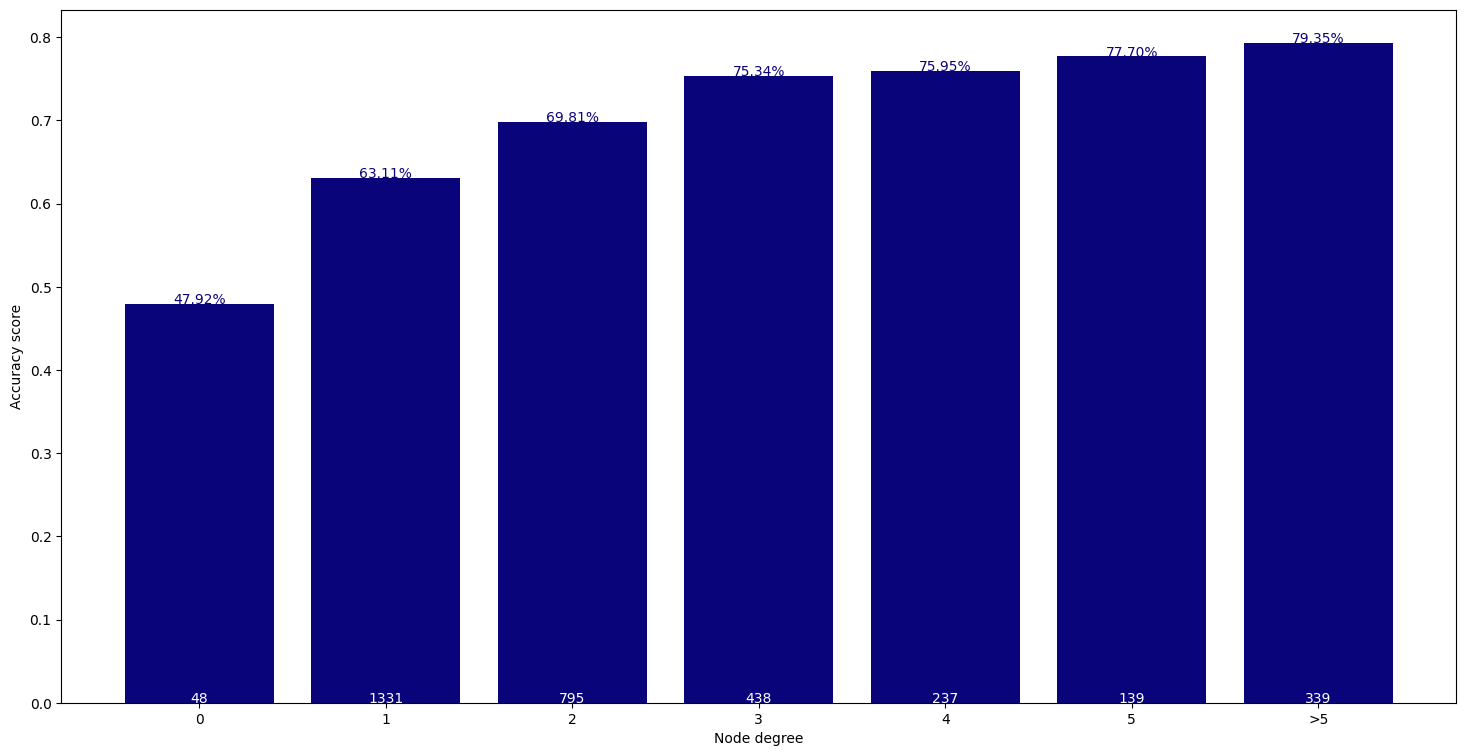

In [18]:
from torch_geometric.utils import degree
import numpy as np
# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

## 2. Graph Isomorphism Network

In [19]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv

In [20]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, num_features, num_classes, dim=16, drop=0.5):
        super(GIN, self).__init__()
        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, num_classes))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_classes)
        self.drop = torch.nn.Dropout(p=0.5)
        
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x, edge_index):
        x = F.selu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.drop(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.bn2(x)
        return x, F.softmax(x, dim=1)

In [21]:
%%time

# Create GIN model
gin = GIN(dataset.num_features, 8, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
CPU times: total: 0 ns
Wall time: 2 ms


In [23]:
# Train
train(gin, data)

# Test
acc = test(gin, data)
print(f'\nGIN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.837 | Train Acc:  56.67% | Val Loss: 1.98 | Val Acc: 34.20%
Epoch   1 | Train Loss: 1.827 | Train Acc:  56.67% | Val Loss: 1.97 | Val Acc: 35.00%
Epoch   2 | Train Loss: 1.800 | Train Acc:  59.17% | Val Loss: 1.97 | Val Acc: 36.40%
Epoch   3 | Train Loss: 1.790 | Train Acc:  64.17% | Val Loss: 1.97 | Val Acc: 34.00%
Epoch   4 | Train Loss: 1.752 | Train Acc:  66.67% | Val Loss: 1.96 | Val Acc: 35.80%
Epoch   5 | Train Loss: 1.773 | Train Acc:  64.17% | Val Loss: 1.97 | Val Acc: 34.60%

GIN test accuracy: 28.70%



### 3. GIN for Graph classification task

In [ ]:
Dataset 

In [24]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting .\PROTEINS\PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 15
Number of features: 3
Number of classes: 2


Done!


### 3D plot

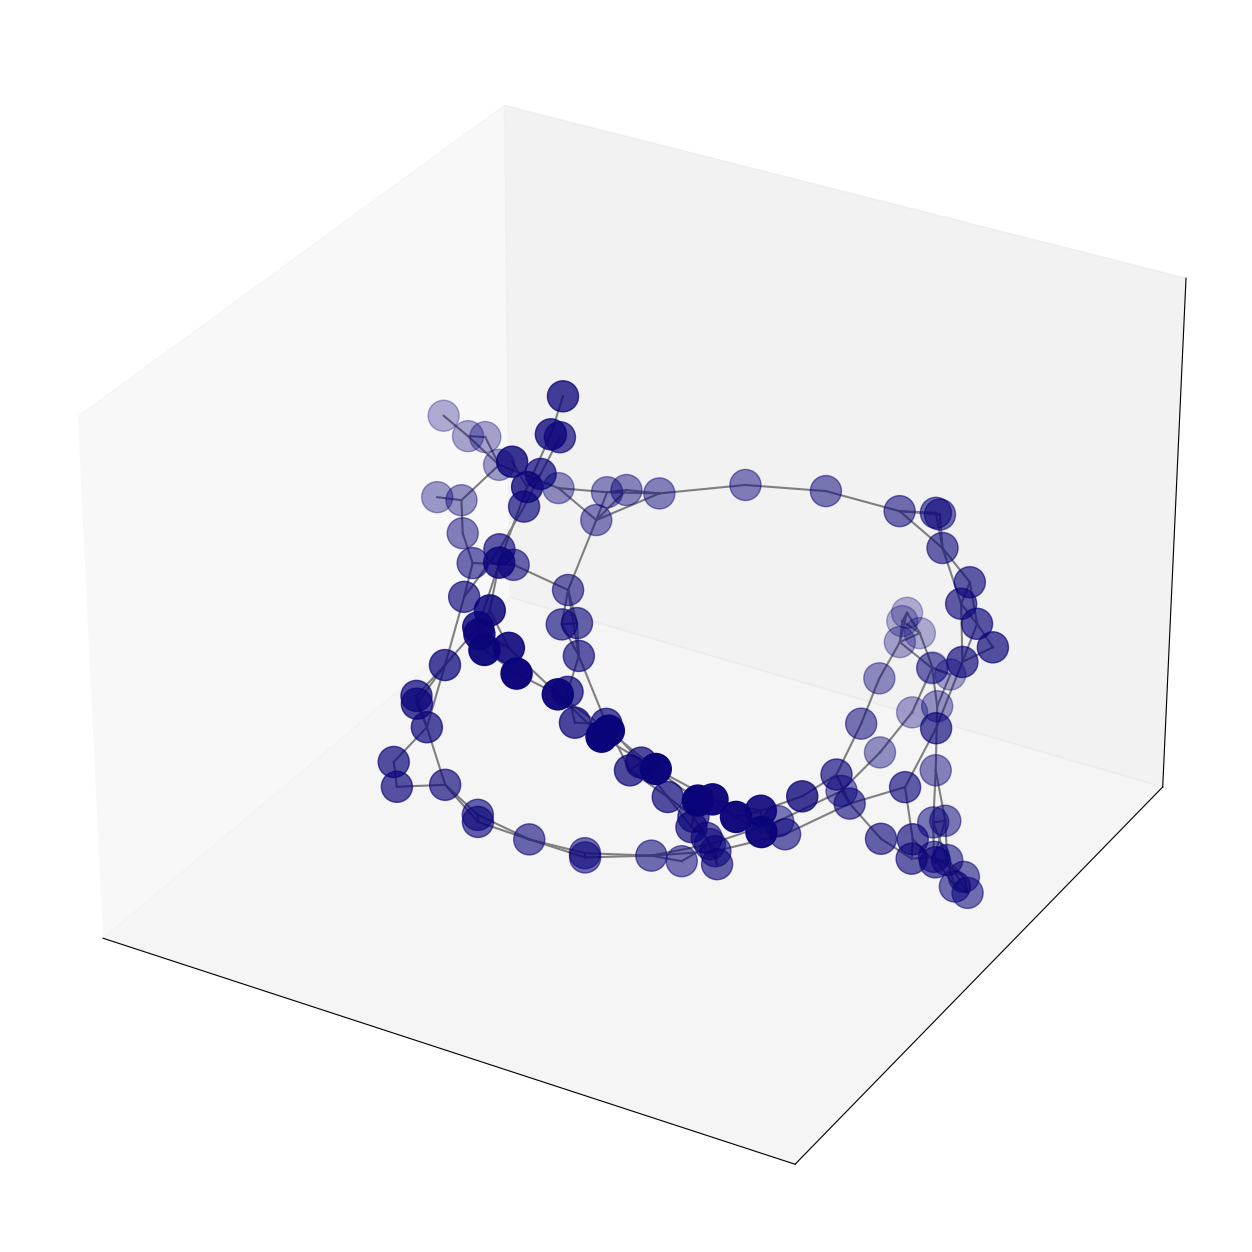

In [26]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

### Mini-batching

In [28]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 7572], x=[2081, 3], y=[64], batch=[2081], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 9798], x=[2578, 3], y=[64], batch=[2578], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 11028], x=[2953, 3], y=[64], batch=[2953], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 9398], x=[2497, 3], y=[64], batch=[2497], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 9624], x=[2626, 3], y=[64], batch=[2626], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 10542], x=[2765, 3], y=[64], batch=[2765], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 7962], x=[2028, 3], y=[64], batch=[2028], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 11332], x=[3093, 3], y=[64], batch=[3093], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 9196], x=[2555, 3], y=[64], batch=[2555], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 8036], x=[2171, 3], y=[64], ba

#### GIN in PyTorch Geometric

In [33]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gin = GIN(dim_h=32)

### Train

In [36]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for data in loader:
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y) / len(loader)
      acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gin = train(gin, train_loader)

Epoch 100 | Train Loss: 0.53 | Train Acc: 75.37% | Val Loss: 0.45 | Val Acc: 77.14%
Test Loss: 0.53 | Test Acc: 80.73%


### Plot graph classification

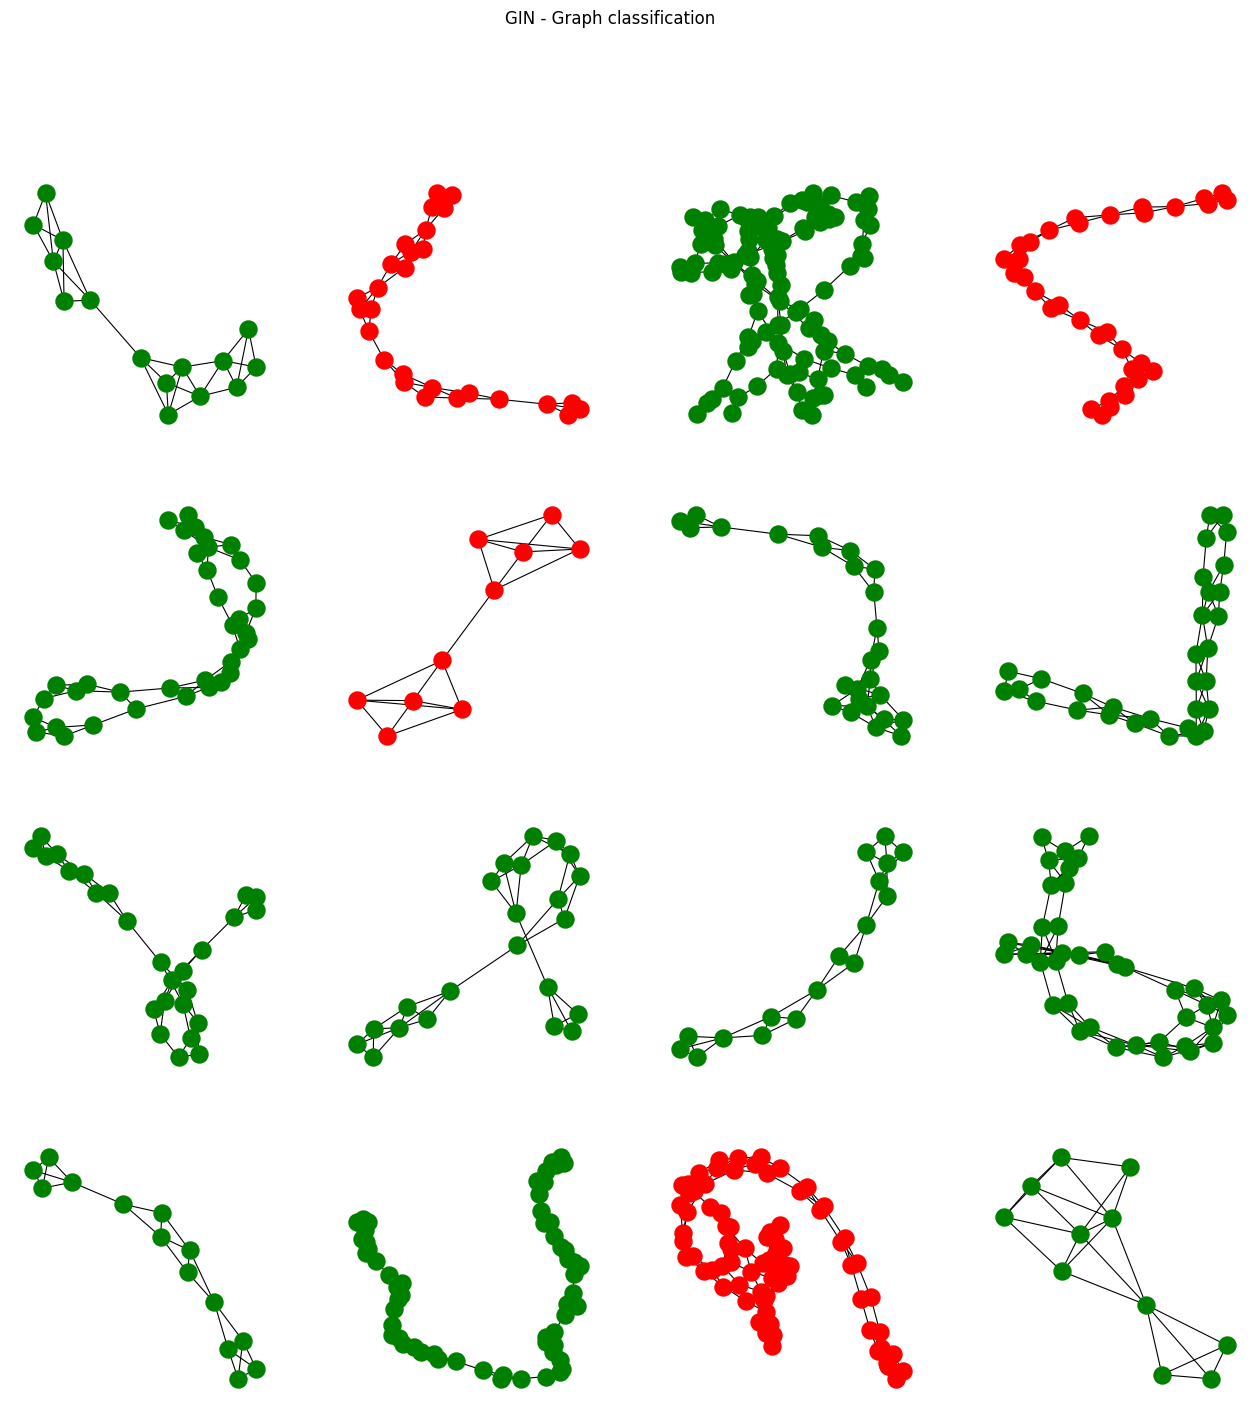

In [38]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )


### Ensemble learning

In [40]:
gin.eval()
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out =  out_gin

    # Calculate accuracy scores
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results

print(f'GIN accuracy:     {acc_gin*100:.2f}%')

GIN accuracy:     80.73%
